### U.S. Election Data Python EDA Project Part I:

This notebook was prepared as the first part of my U.S. Election Data Python EDA Project. The main dataset [1976 - 2020 Presidential Election Results](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX)  is published by MIT Election Data and Science Lab.


In this analysis the data was explored, cleaned, several features were engineered, and finally visualizations were created to reveal the pattern and trend to help answer the main research question which is "which states we should look out for in the coming up 2024 Presidential Election".


**Sections:** 
- [Initial Data Exploration and Preparation](#Initial)
- [Feature Engineering](#Features)
    - [State Level Votes Difference in Percentage](#VoteDiff%)
    - [Number of Tight Races](#TightRace)
    - [Price Shock](#Shock)
- [Missingness](#Missing)
    - [Imputation Strategy](#Impute)
    - [Final Data Prep](#Prep)
- [Visualizations](#Visualizations)
    - [Tight Races Bar Chart](#TightRacesBar)
    - [State Level Votes Diff in Percent Heatmap](#heatmap)
    - [Margin of Victory Lollipop Chart](#Lollipop)
    - [Margin of Victory Scatter Plot](#marginVScatter)
    - [Electoral Map 1976 - 2020](#animation)
    - [Area Plots](#area)
    
- [Conclusion](#Conclusion)
    - [Next Steps](#Next)

### Initial Data Exploration and Preparation<a id='Initial'></a>

First, I loaded the main dataset which contains constituency (state-level) returns for elections to the U.S. presidency from 1976 to 2020. The dataset is clean to begin with so the main challenge for this project is coming up with additional features that are helpful to the analysis.

In the end, I added additional data points such as number of Electoral votes for each state, 2022 citizen population and 2022 GDP in USD for each state before calculating additional features.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import json
import plotly.io as pio
from scipy.stats import pearsonr
from matplotlib.pyplot import figure

In [2]:
# load U.S. State GeoJSON data
geojson_file_path = 'US_State_Boundaries.geojson'

with open(geojson_file_path, 'r') as geojson_file:
    geojson_data = json.load(geojson_file)

In [3]:
# load election results by state csv file
df_state = pd.read_csv('1976-2020-president.csv')
df_state.drop(['state_fips','state_cen', 'office', 
               'writein','version','party_detailed','candidate',
               'notes','state_ic'],axis = 'columns',inplace = True)

In [4]:
# Lets take a look at the missingness in each column
df_state.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4287 entries, 0 to 4286
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              4287 non-null   int64 
 1   state             4287 non-null   object
 2   state_po          4287 non-null   object
 3   candidatevotes    4287 non-null   int64 
 4   totalvotes        4287 non-null   int64 
 5   party_simplified  4287 non-null   object
dtypes: int64(3), object(3)
memory usage: 201.1+ KB


In [5]:
df_state = df_state.groupby(['year','state','state_po',
                            'party_simplified']).agg({'candidatevotes':'sum',
                                                      'totalvotes':'mean'})

df_state.reset_index(drop=False, inplace=True)

In [6]:
# find winner per year per state
group_state = df_state.groupby(['year','state'])
df_state['rank_'] = group_state['candidatevotes'].rank("dense", ascending=False)
df_state['unique_id'] = df_state['year'].astype(str) + df_state['state_po']
df_state

year      state state_po party_simplified  candidatevotes  totalvotes  \
0     1976    ALABAMA       AL         DEMOCRAT          659170   1182850.0   
1     1976    ALABAMA       AL      LIBERTARIAN            1481   1182850.0   
2     1976    ALABAMA       AL            OTHER           18129   1182850.0   
3     1976    ALABAMA       AL       REPUBLICAN          504070   1182850.0   
4     1976     ALASKA       AK         DEMOCRAT           44058    123574.0   
...    ...        ...      ...              ...             ...         ...   
2349  2020  WISCONSIN       WI       REPUBLICAN         1610184   3298041.0   
2350  2020    WYOMING       WY         DEMOCRAT           73491    278503.0   
2351  2020    WYOMING       WY      LIBERTARIAN            5768    278503.0   
2352  2020    WYOMING       WY            OTHER            5685    278503.0   
2353  2020    WYOMING       WY       REPUBLICAN          193559    278503.0   

      rank_ unique_id  
0       1.0    1976AL  
1       4.0    1976AL  
2       3.0    1976AL  
3       2.0    1976AL  
4       2.0    1976AK  
...     ...       ...  
2349    2.0    2020WI  
2350    2.0    2020WY  
2351    3.0    2020WY  
2352    4.0    2020WY  
2353    1.0    2020WY  

[2354 rows x 8 columns]

### Feature Engineering <a id='Features'></a>

In the following sections I added several new features to help us do further analysis of the data.

#### State Level Votes Difference in Percentage: <a id='VoteDiff%'></a>
In the section below I calculated the votes difference in percentage between the Republican party and the Democratic party for each state in each election.

In [7]:
democrat = df_state.query("party_simplified=='DEMOCRAT'")
republican = df_state.query("party_simplified=='REPUBLICAN'")
df_diff = republican.merge(democrat, on = 'unique_id')
#df_diff.rank__x.value_counts()

In [8]:
# calculate vote count difference % for each year between two parties
df_diff.drop(['year_y','state_y','state_po_y','party_simplified_x',
              'party_simplified_y','totalvotes_x',
              'rank__x','rank__y'], axis = 1, inplace = True)


df_diff.rename(columns = {'year_x':'Year', 'state_x':'State','state_po_x':'state_po',
                          'candidatevotes_y':"Dem_votes",'candidatevotes_x':"Rep_votes",
                          'totalvotes_y':'Total_votes'}, inplace = True)

df_diff['Rep_Dem'] = (df_diff['Rep_votes'] - df_diff['Dem_votes']) / df_diff['Total_votes'] *100
df_diff['Rep_Dem_abs'] = abs(df_diff['Rep_Dem'])

In [9]:

# find state with smallest diff per year
group_df_diff = df_diff.groupby(['Year'])
df_diff['rank_'] = group_df_diff['Rep_Dem_abs'].rank("dense", ascending=True)
#df_diff['state'] = df_state['state'].str.title()

#### Number of Tight Races: <a id='TightRace'></a>
In the section below I calculated how many tight races each state had during the past six elections (from 2000 to 2020). Tight race is defined as having the votes difference in percentage between the two parties less than 5%.

In [10]:
df_battle = df_diff[(df_diff['Rep_Dem_abs'] < 5) & (df_diff['Year'] > 1996)]
df_battle_gb = df_battle.groupby('State').size().reset_index(name='num_tight_race')#['state'].count()
df_battle_gb['State'] = df_battle_gb['State'].str.title()
top9_battle = df_battle_gb.sort_values(by='num_tight_race', ascending=False).head(9)
top9_battle

State  num_tight_race
2          Florida               5
20       Wisconsin               4
11          Nevada               4
17    Pennsylvania               4
15            Ohio               4
14  North Carolina               4
7         Michigan               3
8        Minnesota               3
12   New Hampshire               3

In [11]:
df_battle.State.value_counts()

FLORIDA           5
OHIO              4
WISCONSIN         4
PENNSYLVANIA      4
NORTH CAROLINA    4
NEVADA            4
NEW HAMPSHIRE     3
MINNESOTA         3
MICHIGAN          3
NEW MEXICO        2
MISSOURI          2
IOWA              2
COLORADO          2
ARIZONA           2
OREGON            2
VIRGINIA          1
MAINE             1
TENNESSEE         1
MONTANA           1
INDIANA           1
GEORGIA           1
Name: State, dtype: int64

#### Tight Races Bar Chart: <a id='TightRacesBar'></a>
In the seciton below I created a bar chart to show the top states that have the most tight races in the past six elections. This plot will help us identify battleground states that we should be focusing on next year.




In [12]:
fig_bar_battle = px.bar(top9_battle,
                         x='State',
                         y='num_tight_race',
                         text='num_tight_race')
                    

# Update layout
fig_bar_battle.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='number of tight races',
                                title=dict(text='Top 9 states with most tight races from 2000 to 2020',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
fig_bar_battle.write_image('top_battle_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility

fig_bar_battle.show()

#### State Level Votes Diff in Percent Heatmap: <a id='heatmap'></a>

In the section below, I plotted the votes difference in percentage between the Republican party and the Democratic party in each state for each election year in a heatmap. In addition, I grouped states that belong to the same geographical region in the headmap to show pattern in terms of how the political landscape has changed in the past.

In [13]:
# create sub-data frame to plot the heat map
df_heatmap = df_diff[['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap = df_heatmap.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

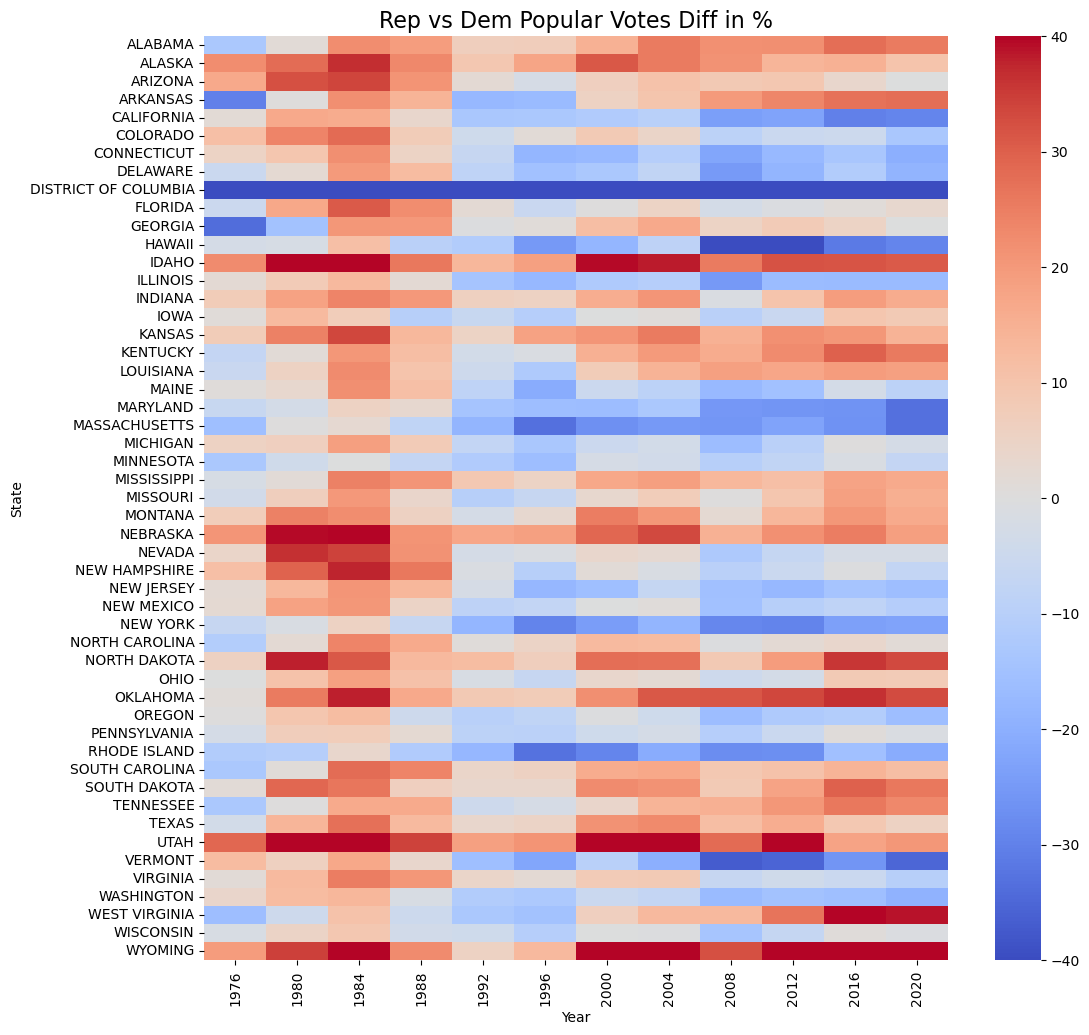

In [14]:
#Plotting the political trend in states
g = sns.heatmap(df_heatmap, vmax = 40, vmin = -40,cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 16, y = 1.0)
g.figure.set_size_inches(12, 12)
fig = g.get_figure()
fig.savefig('State_level_heatmap.jpg')

In [15]:
# create sub-data frame to plot the heat map
df_heatmap_pac = df_diff[df_diff['state_po'].isin(['AK','CA','HI','OR','WA'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_pac = df_heatmap_pac.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

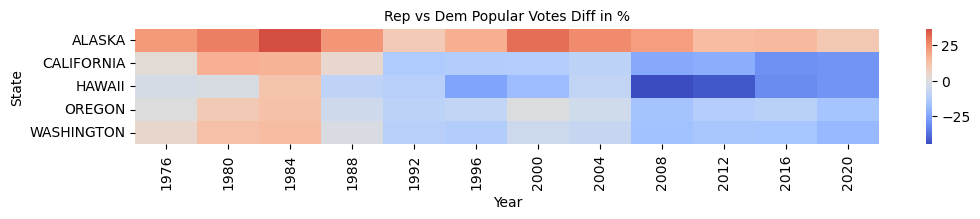

In [16]:
#Plotting the political trend in states
# vmax = 0.4, vmin = -0.4, 
g = sns.heatmap(df_heatmap_pac, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 1.5)
fig = g.get_figure()
fig.savefig('Pacific_heatmap.jpg')


In [17]:
# create sub-data frame to plot the heat map
df_heatmap_ne = df_diff[df_diff['state_po'].isin(['CT','ME','NH','RI','VT','NJ','NY','PA'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_ne = df_heatmap_ne.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

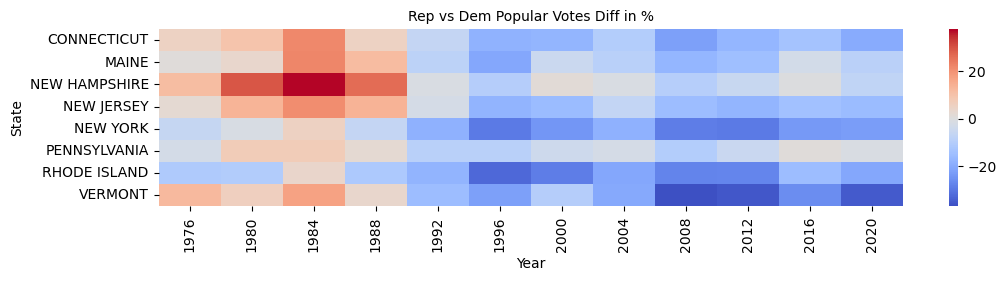

In [18]:
#Plotting the political trend in states
#vmax = 0.4, vmin = -0.4,
g = sns.heatmap(df_heatmap_ne,  cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 2.3)
fig = g.get_figure()
fig.savefig('Northeast_heatmap.jpg')

In [19]:
# create sub-data frame to plot the heat map
df_heatmap_mt = df_diff[df_diff['state_po'].isin(['ID','MT','WY','UT','CO','NM','AZ'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_mt = df_heatmap_mt.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

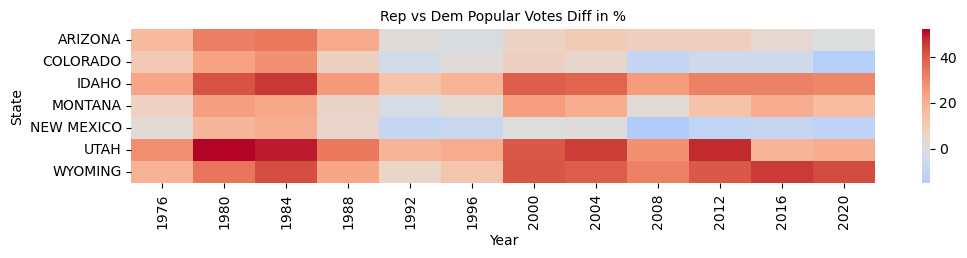

In [20]:
#Plotting the political trend in states
# vmax = 1.0, vmin = -1.0, 
g = sns.heatmap(df_heatmap_mt, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 2)
fig = g.get_figure()
fig.savefig('Mountain_heatmap.jpg')

In [21]:
# create sub-data frame to plot the heat map
df_heatmap_mid_west = df_diff[df_diff['state_po'].isin(['IL','IN','IA','KS',
                                                        'MI','MN','MO','NE',
                                                       'ND','OH','SD','WI'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_mid_west = df_heatmap_mid_west.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

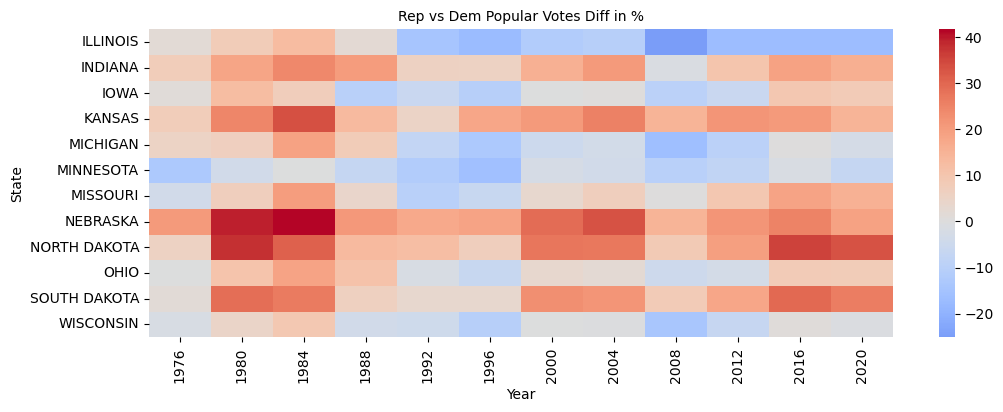

In [22]:
#Plotting the political trend in states
# vmax = 1.0, vmin = -1.0, 
g = sns.heatmap(df_heatmap_mid_west, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 4)
fig = g.get_figure()
fig.savefig('Midwest_heatmap.jpg')

In [23]:
# create sub-data frame to plot the heat map
df_heatmap_south = df_diff[df_diff['state_po'].isin(['AL','AR','DE',#'DC',
                                                     'FL','GA','KY','LA',
                                                     'MS','NC','OK','SC',
                                                    'TN','TX','VA','WV'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_south = df_heatmap_south.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

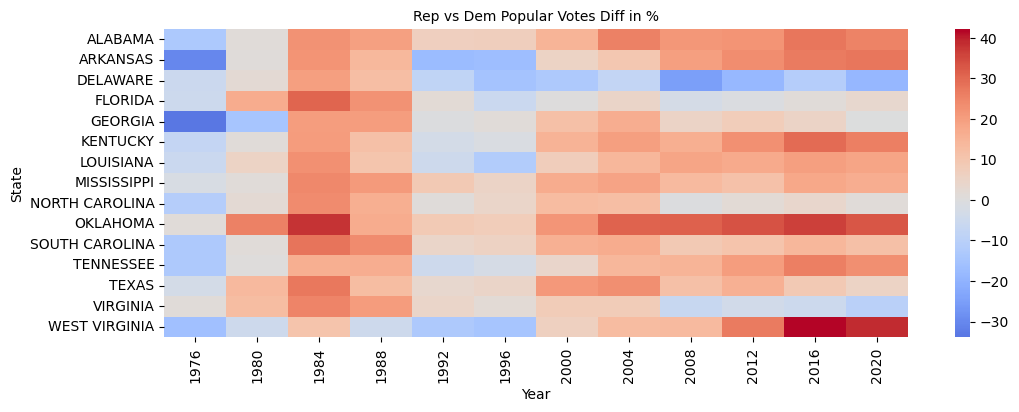

In [24]:
#Plotting the political trend in states
# vmax = 1.0, vmin = -1.0, 
g = sns.heatmap(df_heatmap_south, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 4)
fig = g.get_figure()
fig.savefig('South_heatmap.jpg')

#### Margin of Victory Lollipop Chart: <a id='Lollipop'></a>

Below section is dedicated to calculate 1)the total votes difference between Republican party and Democratic party in each election at the national level and 2)votes difference in percentage between the two parties at national level.

In [25]:
df_national = df_diff.groupby(['Year']).agg({'Rep_votes':'sum',
                                            'Dem_votes':'sum',
                                            'Total_votes':'sum',})
df_national.reset_index(inplace=True)
df_national['Rep_Dem_national'] = round((df_national['Rep_votes'] - df_national['Dem_votes']) /df_national['Total_votes'] *100,1)
df_national['Rep_Dem_national_abs'] = abs(df_national['Rep_Dem_national'])


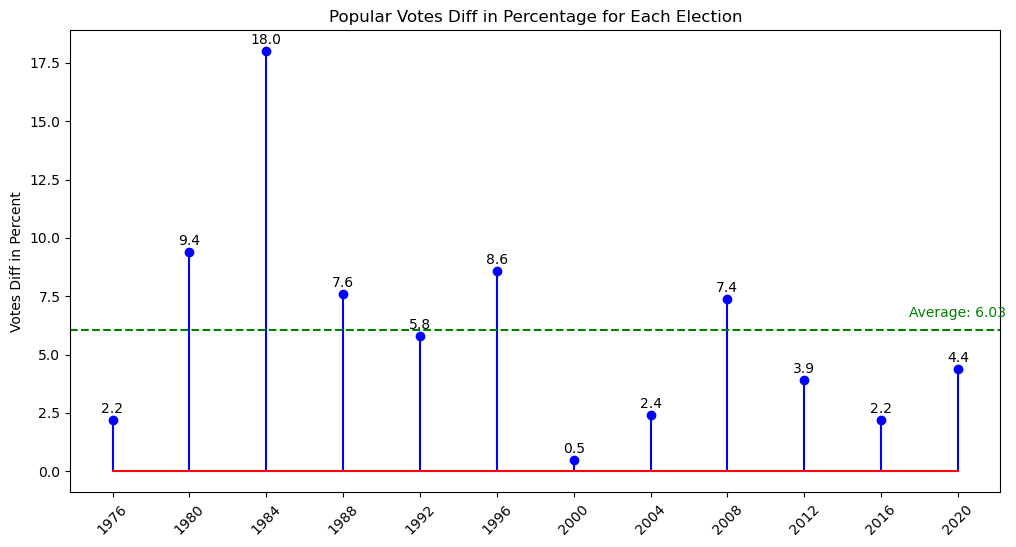

In [26]:
# Plotting the lollipop chart
plt.figure(figsize=(12, 6))

# Plotting the stems
plt.stem(df_national['Year'], df_national['Rep_Dem_national_abs'], linefmt='b-', markerfmt='bo', basefmt='r-')

# Calculate the average of 'df_national.Rep_Dem_national_abs'
avg_percent_diff = df_national.Rep_Dem_national_abs.mean()

# Adding data labels above each stem
for i, value in enumerate(df_national['Rep_Dem_national_abs']):
    plt.annotate(str(value), (df_national['Year'][i], value), textcoords="offset points", xytext=(0, 5), ha='center')

# Adding a line for the average value
plt.axhline(y=avg_percent_diff, color='g', linestyle='--', label='Average Value')

# Adding a data label for the average value
plt.annotate(f'Average: {avg_percent_diff:.2f}', xy=(df_national['Year'].iloc[-1], avg_percent_diff), xytext=(0, 10),
             textcoords='offset points', ha='center', color='g')


# Adding labels and title
#plt.xlabel('Year')
plt.ylabel('Votes Diff in Percent')
plt.title('Popular Votes Diff in Percentage for Each Election')

# Rotating x-axis labels for better readability (optional)
plt.xticks(df_national['Year'], rotation=45)

# Removing grid lines
plt.grid(False)

plt.savefig('Popular_vote_diff_lollipop.png', bbox_inches='tight')

# Display the plot
plt.show()



#### Margin of Victory Scatter Plot: <a id='marginVScatter'></a>

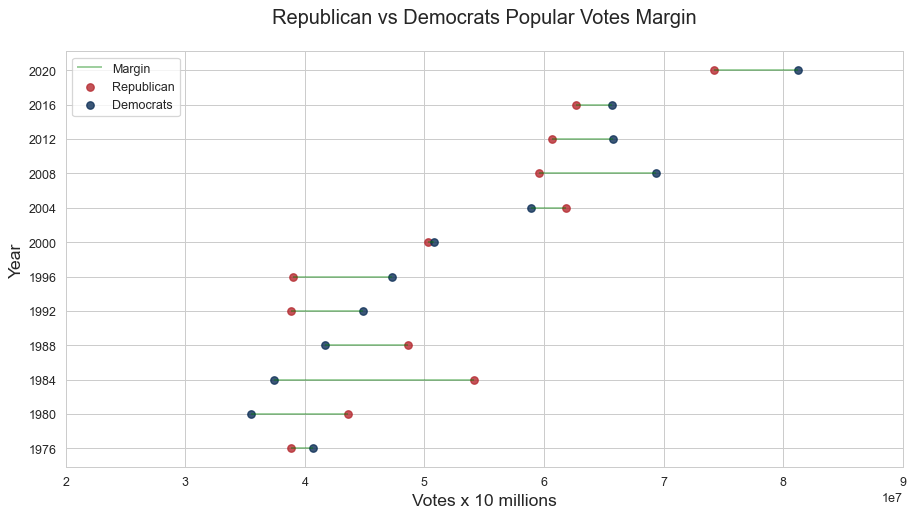

In [27]:
#Plotting the margin of popular votes
my_range=range(1,len(df_national.index)+1)

figure(num=None, figsize=(12, 6), dpi=90, facecolor='w', edgecolor='k')
sns.set_style('whitegrid')

plt.hlines(y = my_range, xmin = df_national['Rep_votes'], 
           xmax =df_national['Dem_votes'], color = 'green', alpha = 0.4)
plt.scatter(df_national['Rep_votes'], my_range, color = '#b4282e', alpha = 0.8)
plt.scatter(df_national['Dem_votes'], my_range, color = '#0b2d55', alpha = 0.8)
plt.legend(['Margin','Republican','Democrats'])
plt.yticks(np.arange(1, 13, step=1), 
           labels = (df_national['Year']))
plt.ylabel('Year', size = 14)
plt.xlim(20000000,90000000)
plt.xlabel('Votes x 10 millions', size = 14)
plt.title('Republican vs Democrats Popular Votes Margin', size = 16, y = 1.05)
plt.savefig('Popular_vote_margin.jpg')

Below section is dedicated to creating the animation that shows Electoral map from 1976 to 2020.

In [28]:
# create data frame that only contains winner from each election per state
df_winner = df_state.loc[df_state['rank_'] == 1.0]
df_winner = df_winner.rename(columns = {'state_po': 'STATE_ABBR',
                                        'party_simplified': 'Party-elected'})
df_winner

year          state STATE_ABBR Party-elected  candidatevotes  \
0     1976        ALABAMA         AL      DEMOCRAT          659170   
7     1976         ALASKA         AK    REPUBLICAN           71555   
11    1976        ARIZONA         AZ    REPUBLICAN          418642   
12    1976       ARKANSAS         AR      DEMOCRAT          498604   
17    1976     CALIFORNIA         CA    REPUBLICAN         3882244   
...    ...            ...        ...           ...             ...   
2335  2020       VIRGINIA         VA      DEMOCRAT         2413568   
2339  2020     WASHINGTON         WA      DEMOCRAT         2369612   
2346  2020  WEST VIRGINIA         WV    REPUBLICAN          545382   
2347  2020      WISCONSIN         WI      DEMOCRAT         1630866   
2353  2020        WYOMING         WY    REPUBLICAN          193559   

      totalvotes  rank_ unique_id  
0      1182850.0    1.0    1976AL  
7       123574.0    1.0    1976AK  
11      742719.0    1.0    1976AZ  
12      767535.0    1.0    1976AR  
17     7803770.0    1.0    1976CA  
...          ...    ...       ...  
2335   4460524.0    1.0    2020VA  
2339   4087631.0    1.0    2020WA  
2346    794652.0    1.0    2020WV  
2347   3298041.0    1.0    2020WI  
2353    278503.0    1.0    2020WY  

[612 rows x 8 columns]

Features are calculated in the section below:
- Number of times each state flipped in the past six elections
- Number of Electoral votes each state has
- Number of Electoral votes per million of citizen population

In [29]:
# calculate how many times State changed preference during the election

df_flip_wip = df_winner.sort_values(by=['STATE_ABBR','year'], ascending=True).copy()

# Create a new column with the previous row's values
df_flip_wip['Previous_party_simplified'] = df_flip_wip['Party-elected'].shift(1)

# Check if the value in row n is the same as row n-1
df_flip_wip['flipped_from_prior'] = df_flip_wip['Party-elected'] != df_flip_wip['Previous_party_simplified']

# drop year 1976 since it does not have a prior year record
df_flip = df_flip_wip.loc[df_flip_wip['year'] > 1996]

# calculate how many times each state flipped
df_flip_group = df_flip.groupby(['STATE_ABBR','state']).agg({'flipped_from_prior':'sum'})

df_flip_group = df_flip_group.reset_index(drop=False)


In [30]:
# load csv that has electoral college data
df_electoral = pd.read_csv('Electoral_College.csv')

In [31]:
# merge df_flip_group with df_electoral
df_flip_electoral = pd.merge(df_flip_group, df_electoral,
                            left_on='STATE_ABBR',
                            right_on='Abb_State',
                             how='left')

In [32]:
df_flip_electoral

STATE_ABBR                 state  flipped_from_prior            Full_State  \
0          AK                ALASKA                   0                Alaska   
1          AL               ALABAMA                   0               Alabama   
2          AR              ARKANSAS                   1              Arkansas   
3          AZ               ARIZONA                   2               Arizona   
4          CA            CALIFORNIA                   0            California   
5          CO              COLORADO                   1              Colorado   
6          CT           CONNECTICUT                   0           Connecticut   
7          DC  DISTRICT OF COLUMBIA                   0  District of Columbia   
8          DE              DELAWARE                   0              Delaware   
9          FL               FLORIDA                   3               Florida   
10         GA               GEORGIA                   1               Georgia   
11         HI                HAWAII                   0                Hawaii   
12         IA                  IOWA                   3                  Iowa   
13         ID                 IDAHO                   0                 Idaho   
14         IL              ILLINOIS                   0              Illinois   
15         IN               INDIANA                   2               Indiana   
16         KS                KANSAS                   0                Kansas   
17         KY              KENTUCKY                   1              Kentucky   
18         LA             LOUISIANA                   1             Louisiana   
19         MA         MASSACHUSETTS                   0         Massachusetts   
20         MD              MARYLAND                   0              Maryland   
21         ME                 MAINE                   0                 Maine   
22         MI              MICHIGAN                   2              Michigan   
23         MN             MINNESOTA                   0             Minnesota   
24         MO              MISSOURI                   1              Missouri   
25         MS           MISSISSIPPI                   0           Mississippi   
26         MT               MONTANA                   0               Montana   
27         NC        NORTH CAROLINA                   2        North Carolina   
28         ND          NORTH DAKOTA                   0          North Dakota   
29         NE              NEBRASKA                   0              Nebraska   
30         NH         NEW HAMPSHIRE                   2         New Hampshire   
31         NJ            NEW JERSEY                   0            New Jersey   
32         NM            NEW MEXICO                   2            New Mexico   
33         NV                NEVADA                   2                Nevada   
34         NY              NEW YORK                   0              New York   
35         OH                  OHIO                   3                  Ohio   
36         OK              OKLAHOMA                   0              Oklahoma   
37         OR                OREGON                   0                Oregon   
38         PA          PENNSYLVANIA                   2          Pennsylvania   
39         RI          RHODE ISLAND                   0          Rhode Island   
40         SC        SOUTH CAROLINA                   0        South Carolina   
41         SD          SOUTH DAKOTA                   0          South Dakota   
42         TN             TENNESSEE                   1             Tennessee   
43         TX                 TEXAS                   0                 Texas   
44         UT                  UTAH                   0                  Utah   
45         VA              VIRGINIA                   1              Virginia   
46         VT               VERMONT                   0               Vermont   
47         WA            WASHINGTON                   0            Washington   
48         WI             WISCONSI

In [103]:
df_citizen_pop = pd.read_csv('state_population.csv',
                             skiprows=range(4),
                             nrows=574,
                             usecols=[0,2,3])

df_citizen_pop = df_citizen_pop.loc[(df_citizen_pop['Characteristics'].isnull() != 1)
                                   & (df_citizen_pop['Characteristics'] != 'UNITED STATES')]

In [104]:
# check the data types
df_citizen_pop.dtypes

Characteristics             object
Total population            object
Total citizen population    object
dtype: object

In [105]:
# convert "Total population" column to float
df_citizen_pop['Total population'] = df_citizen_pop['Total population'].str.replace(',', '').astype(float)
df_citizen_pop['Total citizen population'] = df_citizen_pop['Total citizen population'].str.replace(',', '').astype(float)

#df['your_column_name'] = df['your_column_name'].str.replace(',', '').astype(float)

In [106]:
df_citizen_pop.dtypes

Characteristics              object
Total population            float64
Total citizen population    float64
dtype: object

In [83]:
df_flip_electoral_pop = pd.merge(df_flip_electoral, df_citizen_pop,
                            left_on='state',
                            right_on='Characteristics',
                             how='left')

In [84]:
df_flip_electoral_pop

STATE_ABBR                 state  flipped_from_prior            Full_State  \
0          AK                ALASKA                   0                Alaska   
1          AL               ALABAMA                   0               Alabama   
2          AR              ARKANSAS                   1              Arkansas   
3          AZ               ARIZONA                   2               Arizona   
4          CA            CALIFORNIA                   0            California   
5          CO              COLORADO                   1              Colorado   
6          CT           CONNECTICUT                   0           Connecticut   
7          DC  DISTRICT OF COLUMBIA                   0  District of Columbia   
8          DE              DELAWARE                   0              Delaware   
9          FL               FLORIDA                   3               Florida   
10         GA               GEORGIA                   1               Georgia   
11         HI                HAWAII                   0                Hawaii   
12         IA                  IOWA                   3                  Iowa   
13         ID                 IDAHO                   0                 Idaho   
14         IL              ILLINOIS                   0              Illinois   
15         IN               INDIANA                   2               Indiana   
16         KS                KANSAS                   0                Kansas   
17         KY              KENTUCKY                   1              Kentucky   
18         LA             LOUISIANA                   1             Louisiana   
19         MA         MASSACHUSETTS                   0         Massachusetts   
20         MD              MARYLAND                   0              Maryland   
21         ME                 MAINE                   0                 Maine   
22         MI              MICHIGAN                   2              Michigan   
23         MN             MINNESOTA                   0             Minnesota   
24         MO              MISSOURI                   1              Missouri   
25         MS           MISSISSIPPI                   0           Mississippi   
26         MT               MONTANA                   0               Montana   
27         NC        NORTH CAROLINA                   2        North Carolina   
28         ND          NORTH DAKOTA                   0          North Dakota   
29         NE              NEBRASKA                   0              Nebraska   
30         NH         NEW HAMPSHIRE                   2         New Hampshire   
31         NJ            NEW JERSEY                   0            New Jersey   
32         NM            NEW MEXICO                   2            New Mexico   
33         NV                NEVADA                   2                Nevada   
34         NY              NEW YORK                   0              New York   
35         OH                  OHIO                   3                  Ohio   
36         OK              OKLAHOMA                   0              Oklahoma   
37         OR                OREGON                   0                Oregon   
38         PA          PENNSYLVANIA                   2          Pennsylvania   
39         RI          RHODE ISLAND                   0          Rhode Island   
40         SC        SOUTH CAROLINA                   0        South Carolina   
41         SD          SOUTH DAKOTA                   0          South Dakota   
42         TN             TENNESSEE                   1             Tennessee   
43         TX                 TEXAS                   0                 Texas   
44         UT                  UTAH                   0                  Utah   
45         VA              VIRGINIA                   1              Virginia   
46         VT               VERMONT                   0               Vermont   
47         WA            WASHINGTON                   0            Washington   
48         WI             WISCONSI

In [85]:
df_flip_electoral_pop.drop(['STATE_ABBR','state', 'Characteristics'],
                           axis = 'columns',inplace = True)

In [86]:
# Making population variable in millions, instead of thousands
df_flip_electoral_pop['citizen_pop_mil'] = df_flip_electoral_pop['Total citizen population'] / 1000
df_flip_electoral_pop['pop_mil'] = df_flip_electoral_pop['Total population'] / 1000
df_flip_electoral_pop['elec_per_pop'] = round((df_flip_electoral_pop['Electoral_College_Votes'] / df_flip_electoral_pop['citizen_pop_mil']),2)
df_flip_electoral_pop.rename(columns={'Full_State': 'State'}, inplace=True)
df_flip_electoral_pop

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [39]:
# load and transpose the gdp by state csv file
df_gdp = pd.read_csv('gross domestic product (gdp) by state (dollars).csv',nrows=1).T

In [40]:
# calculate the log for 2022_GDP column and filter the data
df_gdp.reset_index(drop=False, inplace=True)
df_gdp.columns = ['State','2022_GDP']
df_gdp['2022_GDP_log'] = np.log(df_gdp['2022_GDP'])
df_gdp = df_gdp.loc[df_gdp['State'] != 'Years']

In [41]:
# merge df_gdp with df_flip_electoral_pop for visualization
df_flip_electoral_pop_gdp = pd.merge(df_flip_electoral_pop, df_gdp,on='State',how='left')

In [42]:
df_flip_electoral_pop_gdp['2022_GDP_perCapita'] = (df_flip_electoral_pop_gdp['2022_GDP'] / 1000000) / df_flip_electoral_pop_gdp['Total citizen population']
df_flip_electoral_pop_gdp['2022_GDP_mil'] = df_flip_electoral_pop_gdp['2022_GDP'] / 1000000
df_flip_electoral_pop_gdp['2022_GDP_mil_log'] = np.log(df_flip_electoral_pop_gdp['2022_GDP_mil'])
df_flip_electoral_pop_gdp['2022_GDP_perCapita_log'] = np.log(df_flip_electoral_pop_gdp['2022_GDP_perCapita'])

In [43]:
df_flip_electoral_pop_gdp

flipped_from_prior                 State Abb_State  \
0                    0                Alaska        AK   
1                    0               Alabama        AL   
2                    1              Arkansas        AR   
3                    2               Arizona        AZ   
4                    0            California        CA   
5                    1              Colorado        CO   
6                    0           Connecticut        CT   
7                    0  District of Columbia        DC   
8                    0              Delaware        DE   
9                    3               Florida        FL   
10                   1               Georgia        GA   
11                   0                Hawaii        HI   
12                   3                  Iowa        IA   
13                   0                 Idaho        ID   
14                   0              Illinois        IL   
15                   2               Indiana        IN   
16                   0                Kansas        KS   
17                   1              Kentucky        KY   
18                   1             Louisiana        LA   
19                   0         Massachusetts        MA   
20                   0              Maryland        MD   
21                   0                 Maine        ME   
22                   2              Michigan        MI   
23                   0             Minnesota        MN   
24                   1              Missouri        MO   
25                   0           Mississippi        MS   
26                   0               Montana        MT   
27                   2        North Carolina        NC   
28                   0          North Dakota        ND   
29                   0              Nebraska        NE   
30                   2         New Hampshire        NH   
31                   0            New Jersey        NJ   
32                   2            New Mexico        NM   
33                   2                Nevada        NV   
34                   0              New York        NY   
35                   3                  Ohio        OH   
36                   0              Oklahoma        OK   
37                   0                Oregon        OR   
38                   2          Pennsylvania        PA   
39                   0          Rhode Island        RI   
40                   0        South Carolina        SC   
41                   0          South Dakota        SD   
42                   1             Tennessee        TN   
43                   0                 Texas        TX   
44                   0                  Utah        UT   
45                   1              Virginia        VA   
46                   0               Vermont        VT   
47                   0            Washington        WA   
48                   2             Wisconsin        WI   
49                   1         West Virginia        WV   
50                   0               Wyoming        WY   

    Electoral_College_Votes  Total citizen population  citizen_pop_mil  \
0                         3                     516.0            0.516   
1                         9                    3716.0            3.716   
2                         6                    2188.0            2.188   
3                        11                    5093.0            5.093   
4                        54                   25315.0           25.315   
5                        10                    4384.0            4.384   
6                         7                    2527.0            2.527   
7                         3                     476.0            0.476   
8                         3                     754.0            0.754   
9                        30                   15449.0           15.449   
10                       16                    7601.0            7.601   
11                        4                    1019.0            1.019   
12                       

### Visualizations <a id='Visualizations'></a>

Need to put in words

#### Electoral Map 1976 - 2020: <a id='animation'></a>

In [44]:
#create a subset of winner data frame for multi-year visualization
df_winner_visual_muti = df_winner.loc[:, ['year','STATE_ABBR','Party-elected']]
df_winner_visual_muti

year STATE_ABBR Party-elected
0     1976         AL      DEMOCRAT
7     1976         AK    REPUBLICAN
11    1976         AZ    REPUBLICAN
12    1976         AR      DEMOCRAT
17    1976         CA    REPUBLICAN
...    ...        ...           ...
2335  2020         VA      DEMOCRAT
2339  2020         WA      DEMOCRAT
2346  2020         WV    REPUBLICAN
2347  2020         WI      DEMOCRAT
2353  2020         WY    REPUBLICAN

[612 rows x 3 columns]

In [45]:
# plotting multi year election results by state
fig = px.choropleth(
    df_winner_visual_muti, 
    locations="STATE_ABBR",  
    locationmode="USA-states",  
    animation_frame="year",  
    color="Party-elected",  
    color_discrete_map={"REPUBLICAN": "#b4282e", 
                        "DEMOCRAT": "#0b2d55"},
    #title="Electoral College Maps from 1976 to 2020",
    scope="usa", 
)

fig = fig.add_scattergeo(
    locations=df_winner_visual_muti['STATE_ABBR'],
    locationmode="USA-states", 
    text=df_winner_visual_muti['STATE_ABBR'],
    textposition='top center',
    mode='text',name='State',
    textfont=dict(color='#f3f3f3',size=8))

# Set showlegend to False to hide the legend
fig.update_layout(showlegend=False)

#fig.show()

# Export the animation as an HTML file
#pio.write_html(fig, file='1976_2020_Electoral_Map.html')

#### Electoral Votes Map: <a id='electoralvotemap'></a>
Need to put in words

In [46]:
# Create horizontal bar chart
fig = px.bar(df_flip_electoral_pop_gdp.sort_values(by='Electoral_College_Votes', ascending=True),
             x='Electoral_College_Votes', y='State', orientation='h',
             text='Electoral_College_Votes')
             #title='Number of Electoral votes in Each State')

# Set the height of the plot to accommodate all y-axis labels
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False, showline=False, zeroline=False),
                  xaxis_title=None,
                  yaxis_title=None,
                  title=dict(text='Number of Electoral votes in Each State',x = 0.5),
                  height=1000)

# Set the angle of rotation for data labels on the x-axis
fig.update_traces(textangle=0,
                 textposition='outside')

# Show the plot
fig.show()

fig.write_image("elec_bar.png")

In [47]:
# create map with state's electoral votes
fig = px.choropleth(
    df_flip_electoral_pop_gdp, 
    locations="Abb_State",  
    locationmode="USA-states",
    scope="usa",
    labels={'Electoral_College_Votes':'no. of Electoral votes'}
)


fig = fig.add_scattergeo(
    locations=df_flip_electoral_pop_gdp['Abb_State'],
    locationmode="USA-states", 
    text=df_flip_electoral_pop_gdp['Electoral_College_Votes'],
    textposition='middle center',
    mode='text',name='State',
    textfont=dict(color='#f3f3f3',size=10))

# Set showlegend to False to hide the legend
fig.update_layout(
    title=dict(
        text='Number of Electoral votes each state has',
        x= 0.4)#,showlegend=False)
)

fig.show()

fig.write_image("elec_map.png")

In [48]:
# Create horizontal bar chart
fig = px.bar(df_flip_electoral_pop_gdp.sort_values(by='elec_per_pop', ascending=True),
             x='elec_per_pop', y='State', orientation='h',
             text='elec_per_pop')
             #title='Number of Electoral votes in Each State')

# Set the height of the plot to accommodate all y-axis labels
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False, showline=False, zeroline=False),
                  xaxis_title=None,
                  yaxis_title=None,
                  title=dict(text='Number of Electoral votes per million of citizen population',x = 0.5),
                  height=1000)

# Set the angle of rotation for data labels on the x-axis
fig.update_traces(textangle=0,
                 textposition='outside')

# Show the plot
fig.show()

fig.write_image("elec_pop_bar.png")

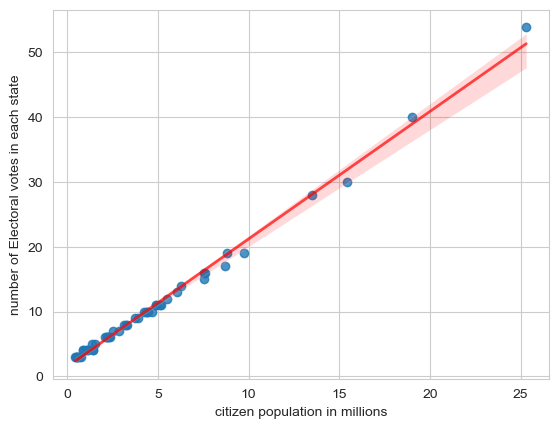

In [49]:
# Create scatterplot
sns.regplot(x=df_flip_electoral_pop_gdp["citizen_pop_mil"], y=df_flip_electoral_pop["Electoral_College_Votes"], line_kws={"color":"r","alpha":0.7,"lw":2})

# Rename the x-axis and y-axis labels
plt.xlabel('citizen population in millions')
plt.ylabel('number of Electoral votes in each state')


# Save plot
plt.savefig('pop_electoral_regression.png', format='png')

plt.show()

In [50]:
x=df_flip_electoral_pop_gdp["citizen_pop_mil"]
y=df_flip_electoral_pop["Electoral_College_Votes"]


# Calculate Pearson correlation coefficient
corr_coefficient, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coefficient}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: 0.9972089847860339
P-value: 6.876105003340896e-57


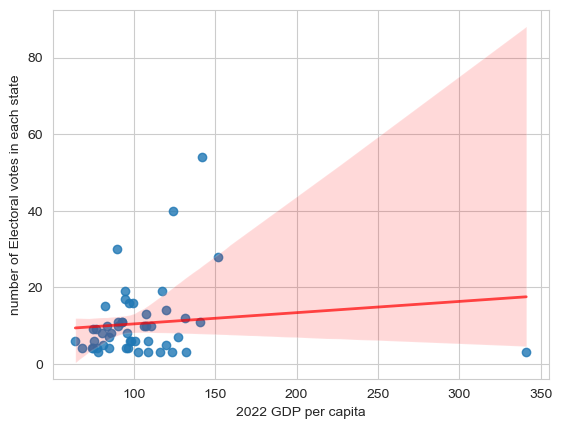

In [51]:
# Create scatterplot
sns.regplot(x=df_flip_electoral_pop_gdp["2022_GDP_perCapita"], y=df_flip_electoral_pop_gdp["Electoral_College_Votes"], line_kws={"color":"r","alpha":0.7,"lw":2})

# Rename the x-axis and y-axis labels
plt.xlabel('2022 GDP per capita')
plt.ylabel('number of Electoral votes in each state')


# Save plot
plt.savefig('gdp_electoral_regression.png', format='png')

plt.show()

In [52]:
x=df_flip_electoral_pop_gdp["2022_GDP_perCapita"]
y=df_flip_electoral_pop_gdp["Electoral_College_Votes"]


# Calculate Pearson correlation coefficient
corr_coefficient, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.12011768346326532
P-value: 0.40113740261833036


In [71]:
# plot the bubble chart
fig = px.scatter(df_flip_electoral_pop_gdp,#.query("elec_per_pop >= 3"),
                 x="2022_GDP_perCapita_log",
                 y="elec_per_pop",
                 size="citizen_pop_mil",
                 color="State",
                 hover_name="State",
                 size_max=60)



# Override x-axis and y-axis labels
fig.update_layout(
    xaxis_title="log of 2022 GDP per capita",
    yaxis_title="Electoral votes per million of population"
)

fig.show()

# Export the bubble chart to a png file
fig.write_image("bubble_chart.png")

In [54]:
# create bubble plot
fig = px.scatter(df_flip_electoral_pop_gdp,#.query("flipped_from_prior>3"),
                 x="Electoral_College_Votes",
                 y="flipped_from_prior",
                 size="citizen_pop_mil",
                 color="State",
                 hover_name="State",
                 text = 'Abb_State',#log_x=True,
                 size_max=60)


# Override x-axis and y-axis labels
fig.update_layout(
    xaxis_title="Electoral Votes per state",
    yaxis_title="number of times state flipped",
    yaxis=dict(
        tickmode='array',
        tickvals=df_flip_electoral_pop_gdp['flipped_from_prior'],
        ticktext=df_flip_electoral_pop_gdp['flipped_from_prior']
    )
)

fig.show()
fig.write_image("bubble_chart_elec_flip_50States.png")

#### Top 10 swing states: <a id='swing'></a>
Need to put in words

In [55]:
top10_flipped = df_flip_electoral_pop_gdp.sort_values(by='flipped_from_prior', ascending=False).head(10)
top10_electoral = df_flip_electoral_pop_gdp.sort_values(by='Electoral_College_Votes', ascending=False).head(10)
top10_electoral_pop = df_flip_electoral_pop_gdp.sort_values(by='elec_per_pop', ascending=False).head(10)

In [56]:
fig_bar_flipped = px.bar(top10_flipped,
                         x='State',
                         y='flipped_from_prior',
                         text='flipped_from_prior')
                    

# Update layout
fig_bar_flipped.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='number of times a state flipped',
                                title=dict(text='Top 10 swing states',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
fig_bar_flipped.write_image('top10_swing_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility

fig_bar_flipped.show()

#### Top 10 states with more "deciding power": <a id='powerbar'></a>
Measured by the number of Electoral votes each state has

In [57]:
fig_bar_electoral = px.bar(top10_electoral,
                           x='State',
                           y='Electoral_College_Votes',
                           text='Electoral_College_Votes')


# Update layout
fig_bar_electoral.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='number of Electoral votes',
                                title=dict(text='Top 10 states and their number of Electoral votes',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
fig_bar_electoral.write_image('electoral_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility


fig_bar_electoral.show()

#### Top 10 states with most "deciding power" : <a id='power2'></a>
Measured by the number of electoral votes per million of population

In [58]:
fig_bar_electoral_pop = px.bar(top10_electoral_pop,
                           x='State',
                           y='elec_per_pop',
                           text='elec_per_pop')


# Update layout
fig_bar_electoral_pop.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='Electoral votes per MM citizen population',
                                title=dict(text='Top 10 states and their Electoral votes per MM citizen population',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
fig_bar_electoral_pop.write_image('electoral_pop_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility


fig_bar_electoral_pop.show()

#### Power Map: <a id='power'></a>
Need to put in words




In [59]:
# plotting power map measured by number of electoral votes
fig = px.choropleth(
    df_flip_electoral_pop_gdp, 
    locations="Abb_State",  
    locationmode="USA-states",
    color_continuous_scale='Purples',
    color="Electoral_College_Votes",  
    #title="Electoral votes map",
    scope="usa",
    #text=(['Abb_State','Electoral_College_Votes']),
    labels={'Electoral_College_Votes':'no. of Electoral votes'}
)


# Set showlegend to False to hide the legend
fig.update_layout(
    title=dict(
        #text='Electoral Power measured by no. of Electoral votes',
        x= 0.4)#,showlegend=False)
)

fig.show()

fig.write_image("elec_map.png")

In [60]:
# plotting power map measured by number of electoral votes per MM of citizen population
fig = px.choropleth(
    df_flip_electoral_pop_gdp, 
    locations="Abb_State",  
    locationmode="USA-states",
    color_continuous_scale='Purples',
    color="elec_per_pop",  
    #title="Electoral Power measured by votes per mil of pop map",
    scope="usa",
    #text=(['Abb_State','Electoral_College_Votes']),
    labels={'elec_per_pop':'Electoral votes per mil of pop'}
)

# Set showlegend to False to hide the legend
fig.update_layout(
    title=dict(
        #text='Electoral Power measured by no. of Electoral votes per mil of pop',
        x= 0.4)#,showlegend=False)
)

    
fig.show()

fig.write_image("elec_pop_map.png")

#### Area plot: <a id='area'></a>
Need to put in words 


Area plots for the 27 focus states.

In [61]:
df_dem = df_diff[(df_diff['State'].isin(['CALIFORNIA', 'DELAWARE','DISTRICT OF COLUMBIA',
                                        'HAWAII', 'ILLINOIS','NEW YORK',
                                        'RHODE ISLAND','VERMONT']))
            & (df_diff['Year'] > 1996) ]

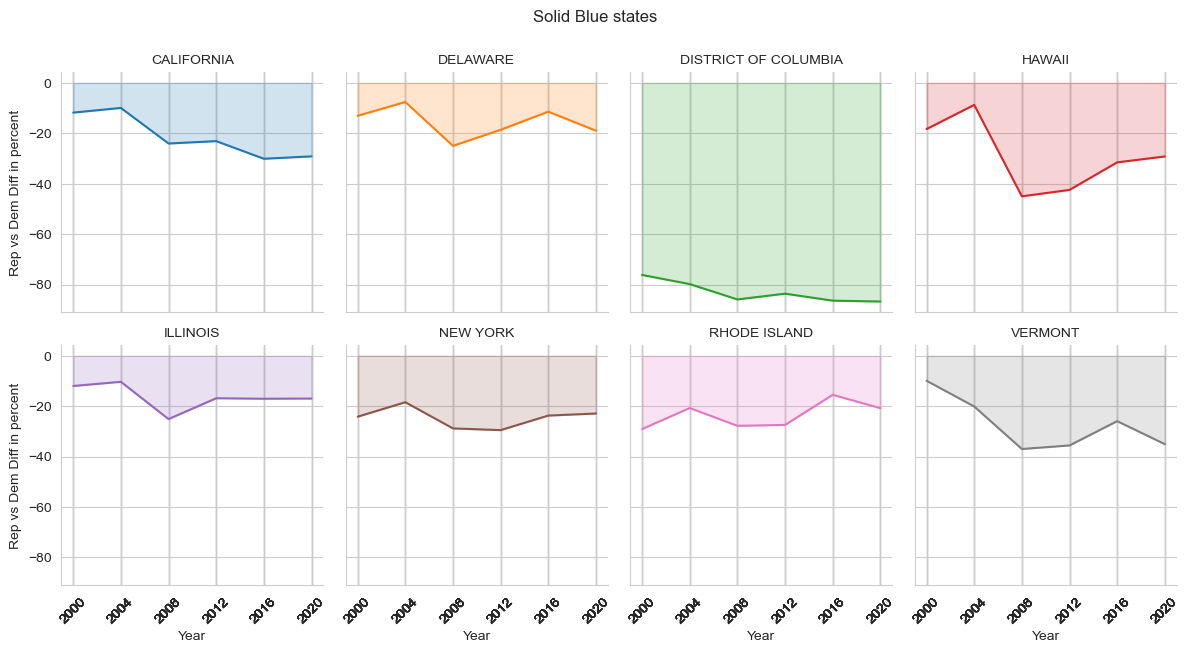

In [62]:
# Create a grid : initialize it
g = sns.FacetGrid(df_dem, col='State', hue='State', col_wrap=4)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Solid Blue states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_dem['Year'])
g.set_xticklabels(df_dem['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('Solid_Blue_area_chart.png')

# Show the graph
plt.show()

In [63]:
df_rep = df_diff[(df_diff['State'].isin(['ALASKA', 'NEBRASKA',
                                        'NORTH DAKOTA', 'SOUTH DAKOTA','WYOMING']))
            & (df_diff['Year'] > 1996) ]

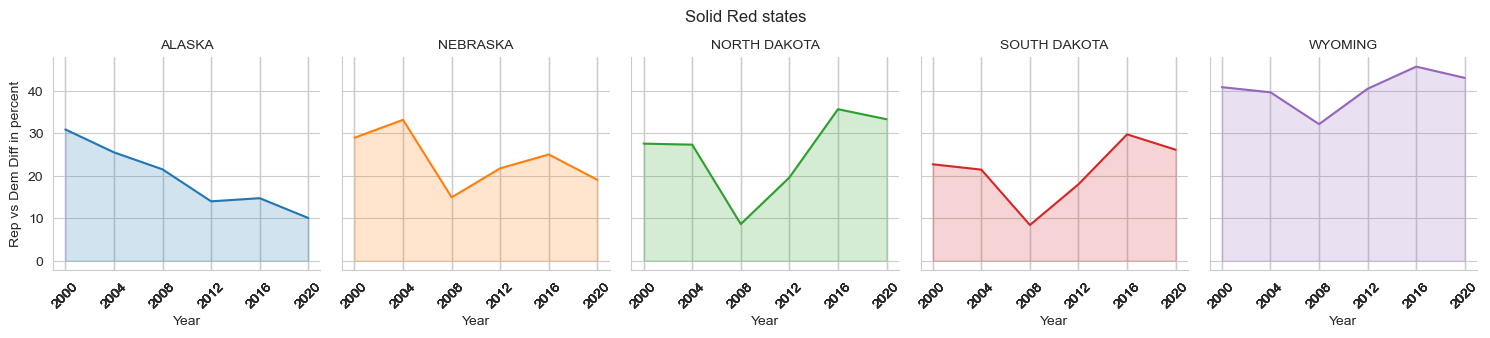

In [64]:
# Create a grid : initialize it
g = sns.FacetGrid(df_rep, col='State', hue='State', col_wrap=5)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Solid Red states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_rep['Year'])
g.set_xticklabels(df_rep['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('Solid_Red_area_chart.png')

# Show the graph
plt.show()

In [65]:
df_focus1 = df_diff[(df_diff['State'].isin(['ARIZONA', 'GEORGIA','NORTH CAROLINA','TEXAS',]))
            & (df_diff['Year'] > 1996) ]

In [66]:
df_focus2 = df_diff[(df_diff['State'].isin(['FLORIDA','MICHIGAN','NEVADA',
                                             'PENNSYLVANIA','WISCONSIN']))
            & (df_diff['Year'] > 1996) ]

In [67]:
df_focus3 = df_diff[(df_diff['State'].isin(['INDIANA','IOWA','MINNESOTA',
                                            'NEW HAMPSHIRE','OHIO']))
            & (df_diff['Year'] > 1996) ]

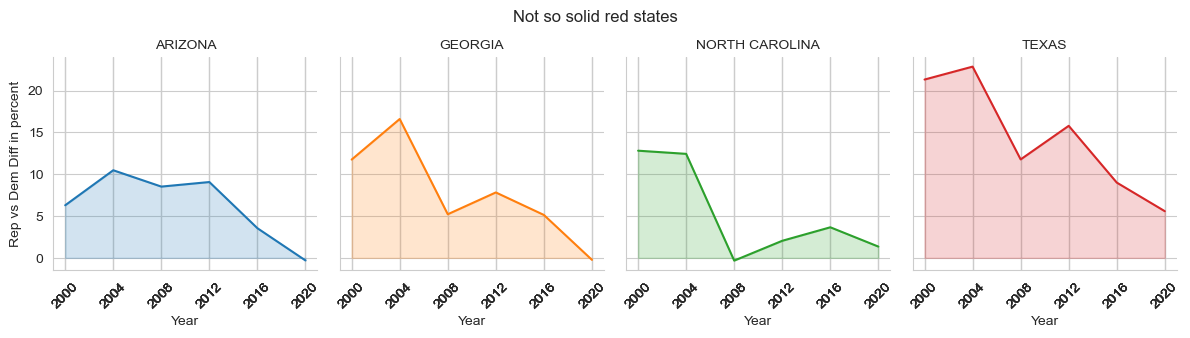

In [68]:
# Create a grid : initialize it
g = sns.FacetGrid(df_focus1, col='State', hue='State', col_wrap=4)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Not so solid red states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_focus1['Year'])
g.set_xticklabels(df_focus1['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('focus1_area_chart.png')

# Show the graph
plt.show()

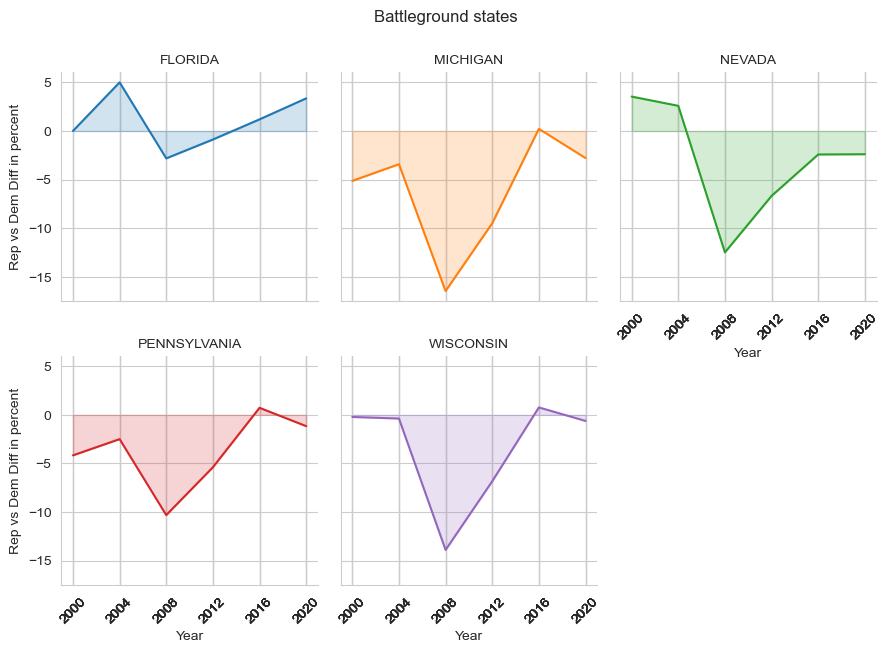

In [69]:
# Create a grid : initialize it
g = sns.FacetGrid(df_focus2, col='State', hue='State', col_wrap=3)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Battleground states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_focus2['Year'])
g.set_xticklabels(df_focus2['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('focus2_area_chart.png')

# Show the graph
plt.show()

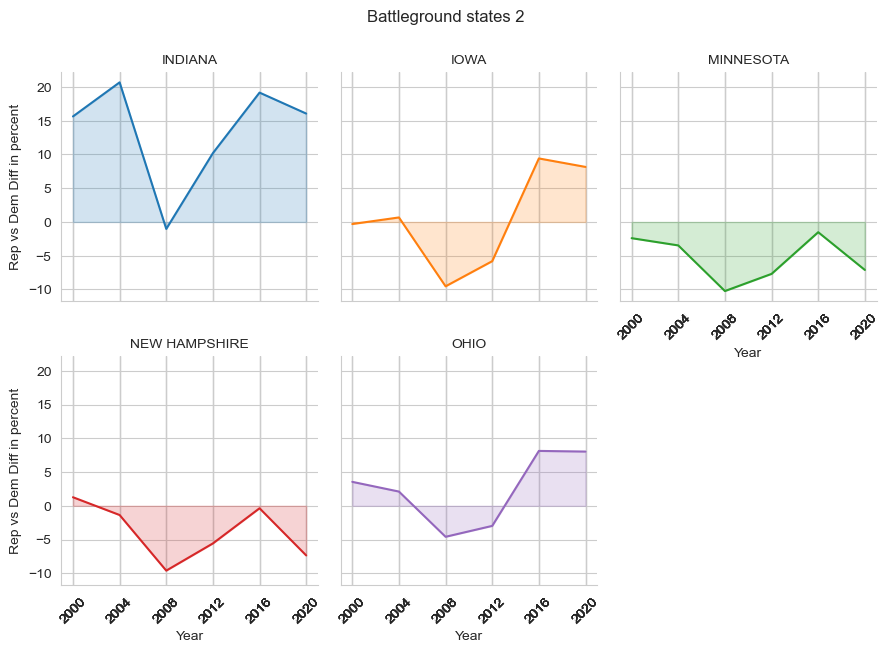

In [70]:
# Create a grid : initialize it
g = sns.FacetGrid(df_focus3, col='State', hue='State', col_wrap=3)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Battleground states 2', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_focus3['Year'])
g.set_xticklabels(df_focus3['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('focus3_area_chart.png')

# Show the graph
plt.show()